# Introducción

En esta tarea abordaremos el problema de clasificaciones de imágenes del data set FashionMNIST, este consta de imagenes de 10 articulos de ropa que buscaremos clasificar.

Para resolverlo utilizaremos la librería pytorch, y con ella buscaremos la arquitectura de red neronal feed forward que logré la mayor accuracy.

Una vez que hayamos seleccionado el mejor modelo lo evaluaremos con matriz de confusión y metrica F1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Seteado de seed para garantizar reproducibilidad

In [3]:
def seeds(seed):
  # Establecer una semilla para Torch, Numpy y Python
  seed = 8

  # Establecer la semilla para Torch
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # Establecer la semilla para Numpy
  np.random.seed(seed)

  # Establecer la semilla para Python (para funciones aleatorias de Python)
  random.seed(seed)

# Cargado de Dataset Fashion MNIST
Cargamos los datos de FashionMNIST usando la librería pytorch que contiene datasets.

In [4]:
# Cargar Datasets Fashion MNIST
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Train-Test split
Tomaremos los conjuntos train y test predeterminados por la librería y separaremos el conjunto de train en train y validación 50.000 (83%) - 10.000 (17%)

In [5]:
seeds(8)
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [6]:
len(training_data)

50000

In [7]:
len(validation_data)

10000

In [8]:
len(test_data)

10000

#### Visualizando los datos a utilizar

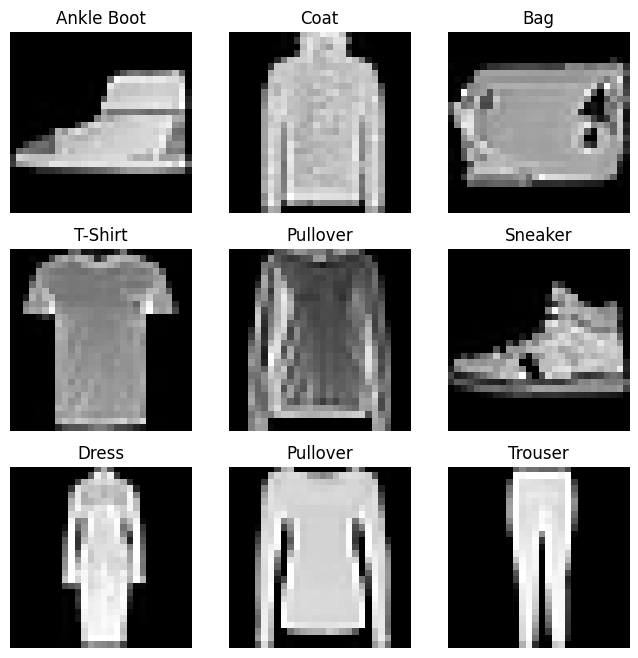

In [9]:

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader

In [10]:
seeds(8)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Definiendo la red neuronal y funciones para entrenamiento
Definimos la clase NeuralNetwork que usaremos para definir nuestra red neruonal, contará con una capa flatten para convertir la imagen de entrada en un vector que será usado por la red. A la hora de inicializar tomará como parámetros la cantidad de capas y unidades por capa como una lista indicando en cada entrada la cantidad de unidades por capa. También daremos como parámetro el tamaño de la inagen de entrada, la cantidad de clases en las que clasificará y también la función de activación que utilizará en las distintas capas. Todas las capas irán a la función sequential que nos definirá nuestra fully-conected feedforward neural network.

### Función forma de activación

In [11]:
def get_activation(activation_name):
    if activation_name == "sigmoid":
        return nn.Sigmoid()
    elif activation_name == "relu":
        return nn.ReLU()
    elif activation_name == "tanh":
        return nn.Tanh()
    elif activation_name == "leaky_relu":
        return nn.LeakyReLU()
    else:
        raise ValueError("Función de activación no válida. Utiliza 'sigmoid', 'relu', 'tanh' o 'leaky_relu'.")

In [12]:
activation_name = "sigmoid"  # Elegir la función de activación deseada
activation = get_activation(activation_name)
activation

Sigmoid()

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_units, input_size, num_classes, activation_name, dropout = 0):
        super().__init__()

        all_layers = [nn.Flatten()]  # Capa flatten para convertir imagen en vector de entrada

        for hidden_unit in hidden_units:  # Agrego capas como indique el parámetro
            layer = nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(get_activation(activation_name))
            input_size = hidden_unit

            if dropout > 0:
              all_layers.append(nn.Dropout(dropout))

        all_layers.append(nn.Linear(hidden_units[-1], num_classes))

        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        logits = self.model(x)
        return logits


image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

In [14]:
activation_name = "sigmoid"
hidden_units = [32]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name,dropout = 0.5)
print(modelo)

NeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Sigmoid()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [15]:
def accuracy(model, dataloader):
    model = model.eval()

    correct = 0.0
    total_examples = 0

    for i, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim = 1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [16]:
def train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(train_dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    plot_loss = []
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            plot_loss.append(loss)

    train_acc = accuracy(model, train_dataloader)
    model.eval() # desactivamos las capas dropout para accuracy en validación
    val_acc = accuracy(model, validation_dataloader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    return train_acc*100, val_acc*100, plot_loss

In [17]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.inference_mode():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
def entrena(modelo, learning_rate, epochs,train_dataloader = train_dataloader, validation_dataloader= validation_dataloader, lmbda = 0):
  '''Esta función entrena el modelo con los parametros indicados. Si se indica un valor de Lambda se regulariza con weight decay con el valor indicado'''
  optimizer = torch.optim.SGD(modelo.parameters(), lr=learning_rate, weight_decay = lmbda)

  loss_fn = nn.CrossEntropyLoss()

  train_acc = []
  val_acc = []
  loss = []

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, v_acc, plot_loss = train_loop(train_dataloader, validation_dataloader, modelo, loss_fn, optimizer)
    train_acc.append(t_acc)
    val_acc.append(v_acc)
    loss.extend(plot_loss)
  return train_acc, val_acc, loss

In [19]:
def evaluacion(loss, train_acc, val_acc, titulo = ""):
  '''Función que describe gráficamente la evolución de una función de pérdida y accuracies de entrenamiento y validación'''
  fig, axs = plt.subplots(1, 2, figsize=(6,3))

  axs[0].plot(loss)
  axs[0].set_title("Evolución de Loss")
  axs[0].set_xlabel("Iteración")

  axs[1].plot(train_acc, label = "Training accuracy")
  axs[1].plot(val_acc, label = "Validation accuracy")

  axs[1].set_title("Evolución de accuracy")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(fontsize=7)

  fig.text(0.5, -0.05, titulo, ha="center", fontsize=7)

  plt.show()

# Linea base
Fijaremos una linea base con una red neuronal muy sencilla con solo 1 capa de 32 unidades y función de activación sigmoide.

In [57]:
seeds(8)
activation_name = "sigmoid"
hidden_units = [32]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.370359  [   64/50000]
loss: 2.294150  [ 6464/50000]
loss: 2.286512  [12864/50000]
loss: 2.312615  [19264/50000]
loss: 2.309018  [25664/50000]
loss: 2.309423  [32064/50000]
loss: 2.255794  [38464/50000]
loss: 2.295155  [44864/50000]
Train Acc 20.81% | Val Acc 20.61%
Epoch 2
-------------------------------
loss: 2.269980  [   64/50000]
loss: 2.279625  [ 6464/50000]
loss: 2.242285  [12864/50000]
loss: 2.257139  [19264/50000]
loss: 2.249644  [25664/50000]
loss: 2.238739  [32064/50000]
loss: 2.230960  [38464/50000]
loss: 2.235752  [44864/50000]
Train Acc 42.64% | Val Acc 42.28%
Epoch 3
-------------------------------
loss: 2.262348  [   64/50000]
loss: 2.232909  [ 6464/50000]
loss: 2.221497  [12864/50000]
loss: 2.205298  [19264/50000]
loss: 2.200567  [25664/50000]
loss: 2.189925  [32064/50000]
loss: 2.186872  [38464/50000]
loss: 2.209659  [44864/50000]
Train Acc 49.58% | Val Acc 49.02%
Epoch 4
-------------------------------
loss: 2.169752  [ 

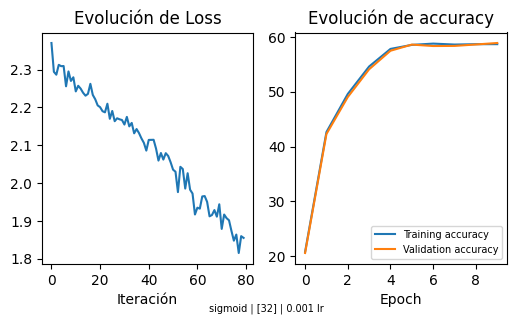

In [63]:
evaluacion(loss, train_acc, val_acc, "sigmoid | [32] | 0.001 lr")

# Búsqueda del mejor modelo

Tenemos una gran variedad de parámetros para utilizar.

Podemos variar:
* Cantidad de capas de la red
* Cantidad de unidades por capa
* Función de activación de las capas
* Learning rate

Dada la inabarcable cantidad de arquitecturas posibles decidimos generar un proceso aleatorio que combine distintas arquitecturas para observar distintas posibilidades. Dejaremos el learning rate fijo, y veremos cuál de todas estas posibilidades reporta mejor accuracy en el conjunto de validación. Con las mejores 3 arquitecturas buscaremos mejorar los resultados variando el learning rate.

In [ ]:
seeds(8)
# Define los rangos de búsqueda
num_layers_range = [1, 2, 3, 4]
num_units_range = [32, 64, 128, 256]
activation = ["sigmoid", 'relu', 'tanh', 'leaky_relu']
num_iterations = 60  # Número de iteraciones de búsqueda

best_config = None
best_accuracy = 0.0

# Asigna un valor inicial para learning_rate
learning_rate = 0.01

# Agrega un bucle para realizar 10 épocas
epochs = 10

for _ in range(num_iterations):
    # Generar configuración aleatoria
    num_layers = random.choice(num_layers_range)
    num_units = random.sample(num_units_range, num_layers)

    # Crear y entrenar modelo con la configuración actual
    activation_name = random.choice(activation)
    hidden_units = num_units
    image_size = training_data[0][0].shape
    input_size = image_size[0] * image_size[1] * image_size[2]

    modelo = NeuralNetwork(hidden_units, input_size, 10, activation_name)

    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% NUEVA CONFIGURACIÓN")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%",num_layers," capas")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%",num_units, " unidades")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%",activation_name," de activación")
    print(f"Iteration {_ + 1}\n-------------------------------")
    train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

    # Almacenar resultados y comparar con el mejor rendimiento previo
    if val_acc[-1] > best_accuracy:
        best_accuracy = val_acc[-1]
        best_config = (num_layers, num_units)

print("/n ##################################################")
print("/n ##################################################")
print("/n ################################################## /n")
print("Mejor configuración encontrada:")
print(f"Número de capas ocultas: {best_config[0]}, Número de unidades ocultas: {best_config[1]}")
print(f"Mejor precisión en validación: {best_accuracy.item():.2f}%")
print("/n ##################################################")
print("/n ##################################################")
print("/n ################################################## /n")

Se han truncado las últimas 5000 líneas del flujo de salida.
loss: 0.478221  [38464/50000]
loss: 0.501021  [44864/50000]
Train Acc 81.98% | Val Acc 82.54%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% NUEVA CONFIGURACIÓN
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 4  capas
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% [32, 256, 128, 64]  unidades
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% relu  de activación
Iteration 18
-------------------------------
Epoch 1
-------------------------------
loss: 2.331358  [   64/50000]
loss: 2.306229  [ 6464/50000]
loss: 2.299535  [12864/50000]
loss: 2.283675  [19264/50000]
loss: 2.293267  [25664/50000]
loss: 2.263983  [32064/50000]
loss: 2.235007  [38464/50000]
loss: 2.175915  [44864/50000]
Train Acc 29.81% | Val Acc 29.81%
Epoch 2
-------------------------------
loss: 2.025531  [   64/50000]
loss: 1.759389  [ 6464/50000]
loss: 1.437078  [12864/50000]
loss: 1.308438  [19264/50000]
loss: 1.206983  [25664/50000]
loss: 1.110924  [32064/50000]
loss: 0.952722  [3

## Pruebas
Luego de 64 iteraciones probando al azar combinaciones de parámetros llegamos a que estas fueron las mejores combinaciones. En todas las iteraciones de mantuvo fijo el learning rate (0.01).

Rápidamente descartamos la función sigmoide como activación y vemos que las arquitecturas con muchas unidades logran buenos resultados aunque no necesariamente las arquitecturas con más profundidad predominaron sobre las otras.

* [32, 256, 64]  unidades
* tanh activación
* Train Acc 85.10% | Val Acc 85.51%
-----
* [128, 256, 64]  unidades
* tanh activación
* Train Acc 85.11% | Val Acc 85.50%
-----
* [32, 256]  unidades
* ReLu activación
* Train Acc 85.10% | Val Acc 85.25%
------
* [256, 32]  unidades
* Relu activación
* Train Acc 84.99% | Val Acc 85.20%
------

### Variación del learning rate 

### Configuración 1

#### Learning rate 0.001

In [17]:
seeds(8)
activation_name = "tanh"
hidden_units = [32, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.293167  [   64/50000]
loss: 2.279263  [ 6464/50000]
loss: 2.273551  [12864/50000]
loss: 2.263268  [19264/50000]
loss: 2.254004  [25664/50000]
loss: 2.237935  [32064/50000]
loss: 2.237103  [38464/50000]
loss: 2.210944  [44864/50000]
Train Acc 33.49% | Val Acc 33.41%
Epoch 2
-------------------------------
loss: 2.195154  [   64/50000]
loss: 2.162292  [ 6464/50000]
loss: 2.163057  [12864/50000]
loss: 2.154438  [19264/50000]
loss: 2.087375  [25664/50000]
loss: 2.075106  [32064/50000]
loss: 2.024996  [38464/50000]
loss: 2.018415  [44864/50000]
Train Acc 36.39% | Val Acc 35.94%
Epoch 3
-------------------------------
loss: 1.987698  [   64/50000]
loss: 1.931695  [ 6464/50000]
loss: 1.902296  [12864/50000]
loss: 1.927128  [19264/50000]
loss: 1.825336  [25664/50000]
loss: 1.852352  [32064/50000]
loss: 1.701931  [38464/50000]
loss: 1.739504  [44864/50000]
Train Acc 46.37% | Val Acc 46.05%
Epoch 4
-------------------------------
loss: 1.668206  [ 

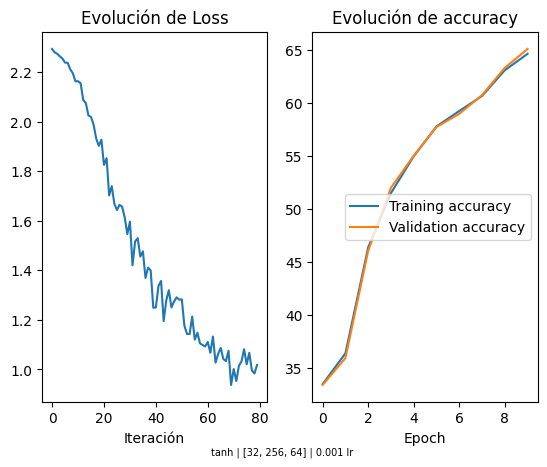

In [18]:
evaluacion(loss, train_acc, val_acc, "tanh | [32, 256, 64] | 0.001 lr")

#### Learning rate 0.01

In [19]:
seeds(8)
activation_name = "tanh"
hidden_units = [32, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.293167  [   64/50000]
loss: 2.157505  [ 6464/50000]
loss: 1.774884  [12864/50000]
loss: 1.513563  [19264/50000]
loss: 1.320623  [25664/50000]
loss: 1.213071  [32064/50000]
loss: 1.180768  [38464/50000]
loss: 1.024620  [44864/50000]
Train Acc 64.94% | Val Acc 65.33%
Epoch 2
-------------------------------
loss: 0.994043  [   64/50000]
loss: 0.830027  [ 6464/50000]
loss: 1.067702  [12864/50000]
loss: 0.929346  [19264/50000]
loss: 0.864729  [25664/50000]
loss: 0.720810  [32064/50000]
loss: 0.759223  [38464/50000]
loss: 0.710926  [44864/50000]
Train Acc 74.83% | Val Acc 75.72%
Epoch 3
-------------------------------
loss: 0.805039  [   64/50000]
loss: 0.662242  [ 6464/50000]
loss: 0.789118  [12864/50000]
loss: 0.782973  [19264/50000]
loss: 0.505329  [25664/50000]
loss: 0.754527  [32064/50000]
loss: 0.615371  [38464/50000]
loss: 0.603193  [44864/50000]
Train Acc 78.52% | Val Acc 79.42%
Epoch 4
-------------------------------
loss: 0.552947  [ 

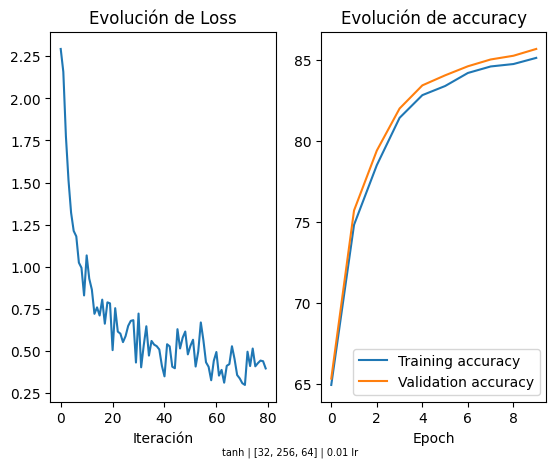

In [20]:
evaluacion(loss, train_acc, val_acc, "tanh | [32, 256, 64] | 0.01 lr")

#### Learning rate 0.1

In [21]:
seeds(8)
activation_name = "tanh"
hidden_units = [32, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.293167  [   64/50000]
loss: 1.084288  [ 6464/50000]
loss: 0.531478  [12864/50000]
loss: 0.668405  [19264/50000]
loss: 0.479950  [25664/50000]
loss: 0.571441  [32064/50000]
loss: 0.612321  [38464/50000]
loss: 0.483076  [44864/50000]
Train Acc 80.73% | Val Acc 81.39%
Epoch 2
-------------------------------
loss: 0.404128  [   64/50000]
loss: 0.285358  [ 6464/50000]
loss: 0.813586  [12864/50000]
loss: 0.562700  [19264/50000]
loss: 0.410984  [25664/50000]
loss: 0.424445  [32064/50000]
loss: 0.412143  [38464/50000]
loss: 0.328869  [44864/50000]
Train Acc 81.32% | Val Acc 82.50%
Epoch 3
-------------------------------
loss: 0.514213  [   64/50000]
loss: 0.482914  [ 6464/50000]
loss: 0.486772  [12864/50000]
loss: 0.430031  [19264/50000]
loss: 0.269114  [25664/50000]
loss: 0.527769  [32064/50000]
loss: 0.406836  [38464/50000]
loss: 0.330767  [44864/50000]
Train Acc 81.84% | Val Acc 81.83%
Epoch 4
-------------------------------
loss: 0.478614  [ 

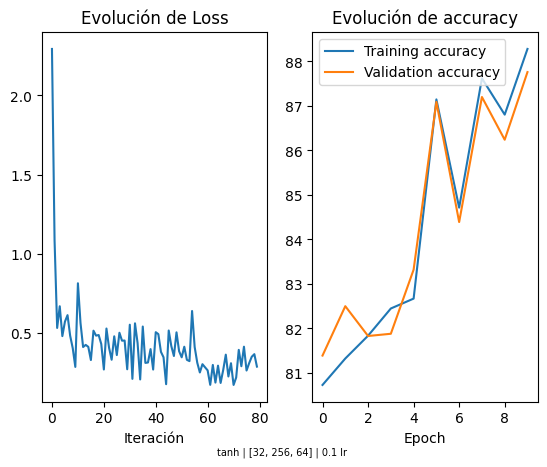

In [22]:
evaluacion(loss, train_acc, val_acc, "tanh | [32, 256, 64] | 0.1 lr")

#### Learning rate 0.3

In [23]:
seeds(8)
activation_name = "tanh"
hidden_units = [32, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.293167  [   64/50000]
loss: 0.917915  [ 6464/50000]
loss: 0.479494  [12864/50000]
loss: 0.585055  [19264/50000]
loss: 0.328068  [25664/50000]
loss: 0.386121  [32064/50000]
loss: 0.561347  [38464/50000]
loss: 0.429504  [44864/50000]
Train Acc 80.14% | Val Acc 80.79%
Epoch 2
-------------------------------
loss: 0.441625  [   64/50000]
loss: 0.280646  [ 6464/50000]
loss: 0.774742  [12864/50000]
loss: 0.588885  [19264/50000]
loss: 0.389760  [25664/50000]
loss: 0.427683  [32064/50000]
loss: 0.458741  [38464/50000]
loss: 0.329800  [44864/50000]
Train Acc 79.58% | Val Acc 80.56%
Epoch 3
-------------------------------
loss: 0.668569  [   64/50000]
loss: 0.461618  [ 6464/50000]
loss: 0.481002  [12864/50000]
loss: 0.431275  [19264/50000]
loss: 0.277765  [25664/50000]
loss: 0.716894  [32064/50000]
loss: 0.372998  [38464/50000]
loss: 0.372668  [44864/50000]
Train Acc 84.35% | Val Acc 84.42%
Epoch 4
-------------------------------
loss: 0.444813  [ 

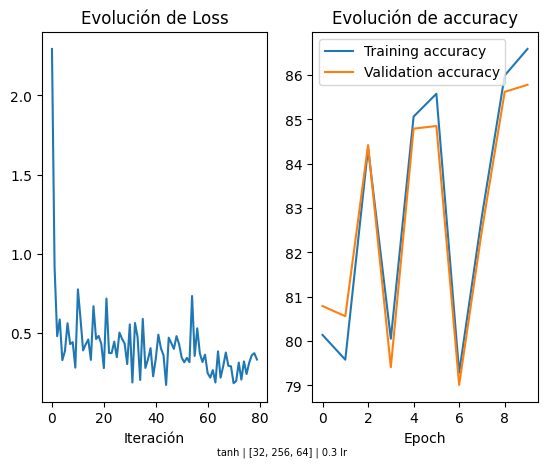

In [24]:
evaluacion(loss, train_acc, val_acc, "tanh | [32, 256, 64] | 0.3 lr")

### Configuración 2

#### Learning rate 0.001

In [25]:
seeds(8)
activation_name = "tanh"
hidden_units = [128, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304827  [   64/50000]
loss: 2.304031  [ 6464/50000]
loss: 2.288854  [12864/50000]
loss: 2.279805  [19264/50000]
loss: 2.265132  [25664/50000]
loss: 2.235273  [32064/50000]
loss: 2.228414  [38464/50000]
loss: 2.211773  [44864/50000]
Train Acc 36.07% | Val Acc 36.14%
Epoch 2
-------------------------------
loss: 2.184352  [   64/50000]
loss: 2.210537  [ 6464/50000]
loss: 2.183932  [12864/50000]
loss: 2.164531  [19264/50000]
loss: 2.140134  [25664/50000]
loss: 2.093791  [32064/50000]
loss: 2.091880  [38464/50000]
loss: 2.085753  [44864/50000]
Train Acc 39.32% | Val Acc 39.64%
Epoch 3
-------------------------------
loss: 2.039560  [   64/50000]
loss: 2.023690  [ 6464/50000]
loss: 1.968163  [12864/50000]
loss: 1.887569  [19264/50000]
loss: 1.856051  [25664/50000]
loss: 1.856479  [32064/50000]
loss: 1.894411  [38464/50000]
loss: 1.788777  [44864/50000]
Train Acc 46.92% | Val Acc 46.97%
Epoch 4
-------------------------------
loss: 1.763132  [ 

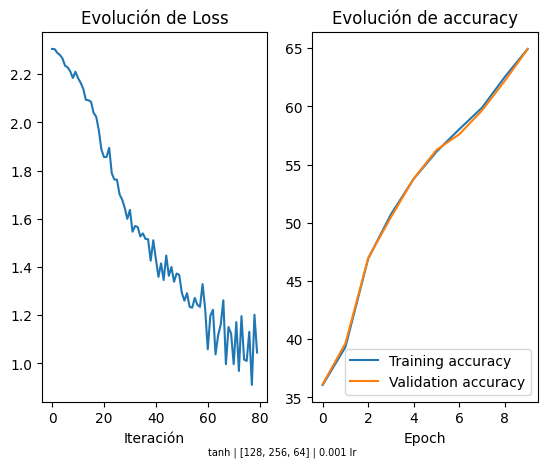

In [26]:
evaluacion(loss, train_acc, val_acc, "tanh | [128, 256, 64] | 0.001 lr")

#### Learning rate 0.01

In [27]:
seeds(8)
activation_name = "tanh"
hidden_units = [128, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304827  [   64/50000]
loss: 2.176664  [ 6464/50000]
loss: 1.903146  [12864/50000]
loss: 1.602922  [19264/50000]
loss: 1.421266  [25664/50000]
loss: 1.294953  [32064/50000]
loss: 1.239663  [38464/50000]
loss: 1.114484  [44864/50000]
Train Acc 64.91% | Val Acc 64.89%
Epoch 2
-------------------------------
loss: 1.054035  [   64/50000]
loss: 1.097116  [ 6464/50000]
loss: 0.899879  [12864/50000]
loss: 0.840390  [19264/50000]
loss: 0.877979  [25664/50000]
loss: 0.736076  [32064/50000]
loss: 0.732955  [38464/50000]
loss: 0.821867  [44864/50000]
Train Acc 73.93% | Val Acc 74.55%
Epoch 3
-------------------------------
loss: 0.642209  [   64/50000]
loss: 0.684933  [ 6464/50000]
loss: 0.634943  [12864/50000]
loss: 0.667604  [19264/50000]
loss: 0.631755  [25664/50000]
loss: 0.708715  [32064/50000]
loss: 0.819438  [38464/50000]
loss: 0.635445  [44864/50000]
Train Acc 78.06% | Val Acc 78.77%
Epoch 4
-------------------------------
loss: 0.595844  [ 

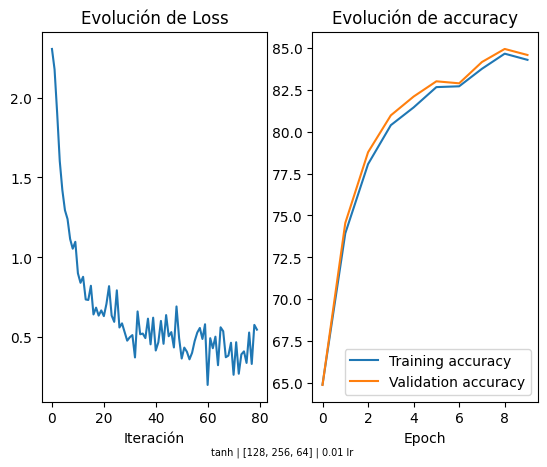

In [28]:
evaluacion(loss, train_acc, val_acc, "tanh | [128, 256, 64] | 0.01 lr")

#### Learning rate 0.1

In [29]:
seeds(8)
activation_name = "tanh"
hidden_units = [128, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304827  [   64/50000]
loss: 0.869507  [ 6464/50000]
loss: 0.576703  [12864/50000]
loss: 0.551262  [19264/50000]
loss: 0.635899  [25664/50000]
loss: 0.596260  [32064/50000]
loss: 0.588603  [38464/50000]
loss: 0.612596  [44864/50000]
Train Acc 79.13% | Val Acc 80.00%
Epoch 2
-------------------------------
loss: 0.546847  [   64/50000]
loss: 0.761566  [ 6464/50000]
loss: 0.477424  [12864/50000]
loss: 0.373868  [19264/50000]
loss: 0.417150  [25664/50000]
loss: 0.328391  [32064/50000]
loss: 0.565197  [38464/50000]
loss: 0.383565  [44864/50000]
Train Acc 84.19% | Val Acc 84.99%
Epoch 3
-------------------------------
loss: 0.421303  [   64/50000]
loss: 0.398305  [ 6464/50000]
loss: 0.370828  [12864/50000]
loss: 0.327408  [19264/50000]
loss: 0.317870  [25664/50000]
loss: 0.491062  [32064/50000]
loss: 0.646026  [38464/50000]
loss: 0.364038  [44864/50000]
Train Acc 84.10% | Val Acc 84.41%
Epoch 4
-------------------------------
loss: 0.384100  [ 

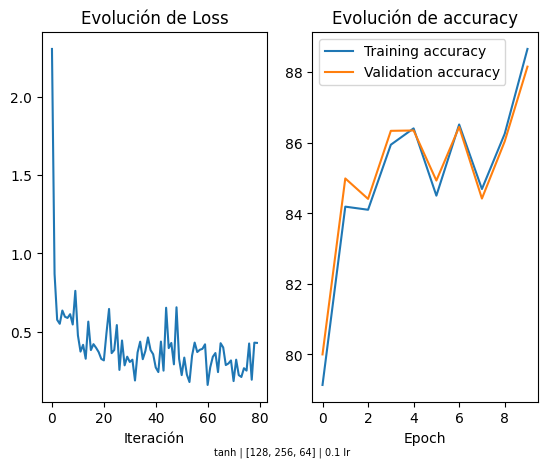

In [30]:
evaluacion(loss, train_acc, val_acc, "tanh | [128, 256, 64] | 0.1 lr")

#### Learning rate 0.3

In [33]:
seeds(8)
activation_name = "tanh"
hidden_units = [128, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304827  [   64/50000]
loss: 0.720792  [ 6464/50000]
loss: 0.549572  [12864/50000]
loss: 0.592336  [19264/50000]
loss: 0.583892  [25664/50000]
loss: 0.552301  [32064/50000]
loss: 0.501295  [38464/50000]
loss: 0.643797  [44864/50000]
Train Acc 71.23% | Val Acc 71.41%
Epoch 2
-------------------------------
loss: 0.735905  [   64/50000]
loss: 0.704172  [ 6464/50000]
loss: 0.528937  [12864/50000]
loss: 0.295892  [19264/50000]
loss: 0.401588  [25664/50000]
loss: 0.320384  [32064/50000]
loss: 0.554510  [38464/50000]
loss: 0.343151  [44864/50000]
Train Acc 82.92% | Val Acc 83.04%
Epoch 3
-------------------------------
loss: 0.419523  [   64/50000]
loss: 0.422581  [ 6464/50000]
loss: 0.382454  [12864/50000]
loss: 0.318668  [19264/50000]
loss: 0.322600  [25664/50000]
loss: 0.521177  [32064/50000]
loss: 0.636643  [38464/50000]
loss: 0.355186  [44864/50000]
Train Acc 85.40% | Val Acc 85.34%
Epoch 4
-------------------------------
loss: 0.385791  [ 

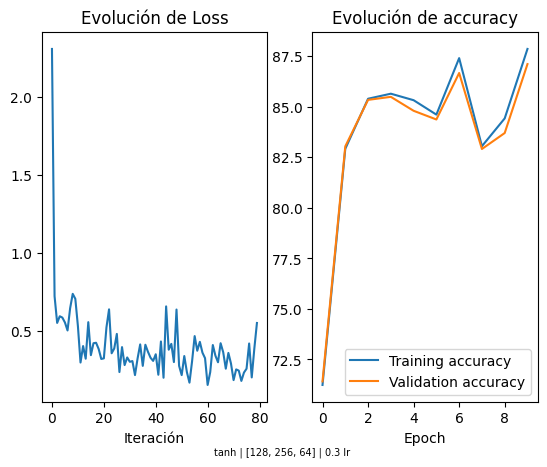

In [34]:
evaluacion(loss, train_acc, val_acc, "tanh | [128, 256, 64] | 0.3 lr")

### Configuración 3

#### Learning rate 0.001

In [35]:
seeds(8)
activation_name = "relu"
hidden_units = [32, 256]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304502  [   64/50000]
loss: 2.292033  [ 6464/50000]
loss: 2.294986  [12864/50000]
loss: 2.278265  [19264/50000]
loss: 2.274185  [25664/50000]
loss: 2.265724  [32064/50000]
loss: 2.248485  [38464/50000]
loss: 2.253054  [44864/50000]
Train Acc 30.83% | Val Acc 30.11%
Epoch 2
-------------------------------
loss: 2.233256  [   64/50000]
loss: 2.211378  [ 6464/50000]
loss: 2.204636  [12864/50000]
loss: 2.188433  [19264/50000]
loss: 2.163584  [25664/50000]
loss: 2.137672  [32064/50000]
loss: 2.126777  [38464/50000]
loss: 2.041946  [44864/50000]
Train Acc 40.58% | Val Acc 40.96%
Epoch 3
-------------------------------
loss: 2.028558  [   64/50000]
loss: 2.016099  [ 6464/50000]
loss: 1.923117  [12864/50000]
loss: 1.995731  [19264/50000]
loss: 1.907726  [25664/50000]
loss: 1.911824  [32064/50000]
loss: 1.752458  [38464/50000]
loss: 1.692062  [44864/50000]
Train Acc 52.44% | Val Acc 53.04%
Epoch 4
-------------------------------
loss: 1.732509  [ 

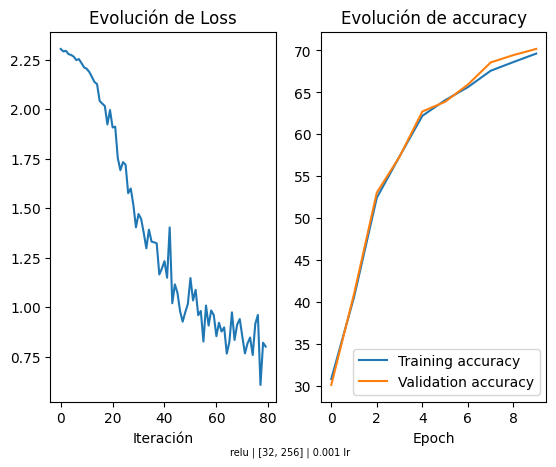

In [36]:
evaluacion(loss, train_acc, val_acc, "relu | [32, 256] | 0.001 lr")

#### Learning rate 0.01

In [37]:
seeds(8)
activation_name = "relu"
hidden_units = [32, 256]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304502  [   64/50000]
loss: 2.192692  [ 6464/50000]
loss: 1.906942  [12864/50000]
loss: 1.446819  [19264/50000]
loss: 1.185994  [25664/50000]
loss: 1.071333  [32064/50000]
loss: 0.905299  [38464/50000]
loss: 0.919176  [44864/50000]
Train Acc 68.65% | Val Acc 68.78%
Epoch 2
-------------------------------
loss: 0.808346  [   64/50000]
loss: 0.826861  [ 6464/50000]
loss: 0.753828  [12864/50000]
loss: 0.688988  [19264/50000]
loss: 0.651326  [25664/50000]
loss: 0.855803  [32064/50000]
loss: 0.716178  [38464/50000]
loss: 0.721084  [44864/50000]
Train Acc 72.52% | Val Acc 72.49%
Epoch 3
-------------------------------
loss: 0.618833  [   64/50000]
loss: 0.790695  [ 6464/50000]
loss: 0.755550  [12864/50000]
loss: 0.830434  [19264/50000]
loss: 0.664712  [25664/50000]
loss: 0.797220  [32064/50000]
loss: 0.425762  [38464/50000]
loss: 0.614893  [44864/50000]
Train Acc 79.12% | Val Acc 79.39%
Epoch 4
-------------------------------
loss: 0.689099  [ 

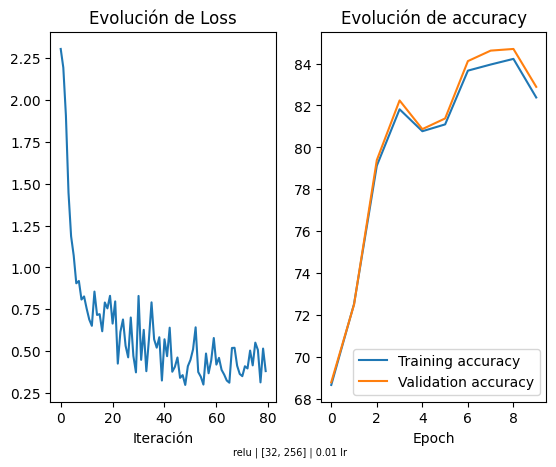

In [38]:
evaluacion(loss, train_acc, val_acc, "relu | [32, 256] | 0.01 lr")

#### Learning rate 0.1

In [39]:
seeds(8)
activation_name = "relu"
hidden_units = [32, 256]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304502  [   64/50000]
loss: 0.938641  [ 6464/50000]
loss: 0.434778  [12864/50000]
loss: 0.685145  [19264/50000]
loss: 0.743536  [25664/50000]
loss: 0.550496  [32064/50000]
loss: 0.623606  [38464/50000]
loss: 0.582084  [44864/50000]
Train Acc 79.80% | Val Acc 80.31%
Epoch 2
-------------------------------
loss: 0.415835  [   64/50000]
loss: 0.449526  [ 6464/50000]
loss: 0.305560  [12864/50000]
loss: 0.359337  [19264/50000]
loss: 0.391713  [25664/50000]
loss: 0.476807  [32064/50000]
loss: 0.540773  [38464/50000]
loss: 0.371686  [44864/50000]
Train Acc 78.47% | Val Acc 78.68%
Epoch 3
-------------------------------
loss: 0.440140  [   64/50000]
loss: 0.699873  [ 6464/50000]
loss: 0.435324  [12864/50000]
loss: 0.497351  [19264/50000]
loss: 0.487942  [25664/50000]
loss: 0.481356  [32064/50000]
loss: 0.343649  [38464/50000]
loss: 0.468505  [44864/50000]
Train Acc 79.87% | Val Acc 79.67%
Epoch 4
-------------------------------
loss: 0.733684  [ 

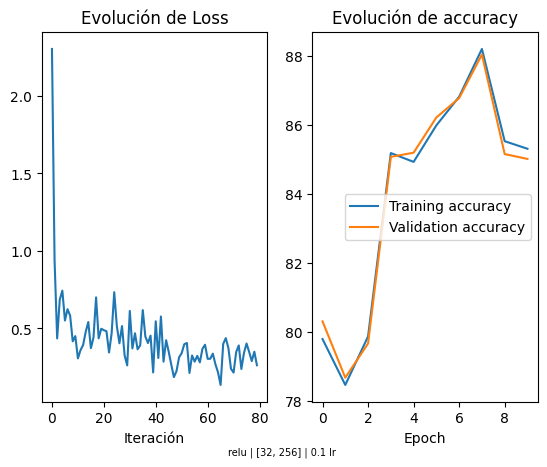

In [40]:
evaluacion(loss, train_acc, val_acc, "relu | [32, 256] | 0.1 lr")

#### Learning rate 0.3

In [41]:
seeds(8)
activation_name = "relu"
hidden_units = [32, 256]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.304502  [   64/50000]
loss: 0.864153  [ 6464/50000]
loss: 0.465066  [12864/50000]
loss: 0.700673  [19264/50000]
loss: 0.890969  [25664/50000]
loss: 0.470571  [32064/50000]
loss: 0.684604  [38464/50000]
loss: 0.573886  [44864/50000]
Train Acc 77.94% | Val Acc 78.33%
Epoch 2
-------------------------------
loss: 0.535700  [   64/50000]
loss: 0.465669  [ 6464/50000]
loss: 0.291988  [12864/50000]
loss: 0.366560  [19264/50000]
loss: 0.382113  [25664/50000]
loss: 0.482442  [32064/50000]
loss: 0.557933  [38464/50000]
loss: 0.410112  [44864/50000]
Train Acc 76.24% | Val Acc 76.18%
Epoch 3
-------------------------------
loss: 0.467677  [   64/50000]
loss: 0.735197  [ 6464/50000]
loss: 0.526213  [12864/50000]
loss: 0.459215  [19264/50000]
loss: 0.552522  [25664/50000]
loss: 0.451483  [32064/50000]
loss: 0.316820  [38464/50000]
loss: 0.405961  [44864/50000]
Train Acc 74.79% | Val Acc 74.75%
Epoch 4
-------------------------------
loss: 0.987556  [ 

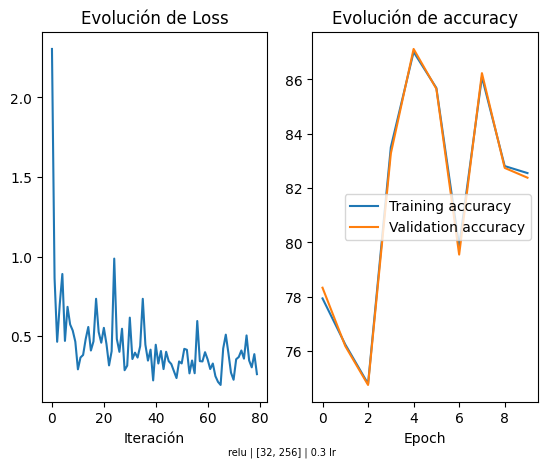

In [42]:
evaluacion(loss, train_acc, val_acc, "relu | [32, 256] | 0.3 lr")

### Configuración 4

#### Learning rate 0.001

In [43]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 2.304561  [ 6464/50000]
loss: 2.330420  [12864/50000]
loss: 2.284890  [19264/50000]
loss: 2.269462  [25664/50000]
loss: 2.288758  [32064/50000]
loss: 2.259638  [38464/50000]
loss: 2.246686  [44864/50000]
Train Acc 23.91% | Val Acc 24.09%
Epoch 2
-------------------------------
loss: 2.254491  [   64/50000]
loss: 2.235934  [ 6464/50000]
loss: 2.230974  [12864/50000]
loss: 2.222604  [19264/50000]
loss: 2.240712  [25664/50000]
loss: 2.201396  [32064/50000]
loss: 2.214530  [38464/50000]
loss: 2.205272  [44864/50000]
Train Acc 30.22% | Val Acc 30.94%
Epoch 3
-------------------------------
loss: 2.194418  [   64/50000]
loss: 2.156702  [ 6464/50000]
loss: 2.136286  [12864/50000]
loss: 2.139057  [19264/50000]
loss: 2.129491  [25664/50000]
loss: 2.028793  [32064/50000]
loss: 2.140629  [38464/50000]
loss: 2.088745  [44864/50000]
Train Acc 33.55% | Val Acc 33.88%
Epoch 4
-------------------------------
loss: 2.076121  [ 

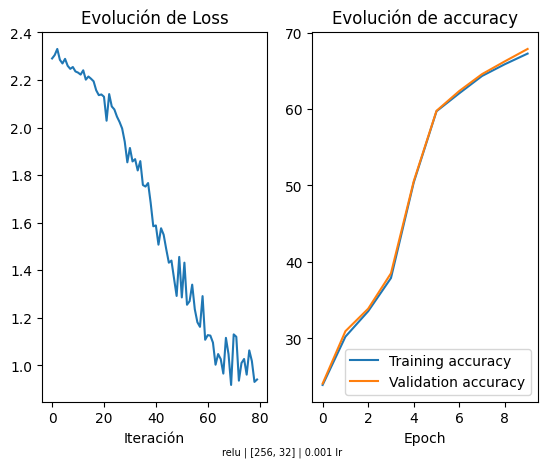

In [44]:
evaluacion(loss, train_acc, val_acc, "relu | [256, 32] | 0.001 lr")

#### Learning rate 0.01

In [45]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 2.237554  [ 6464/50000]
loss: 2.178858  [12864/50000]
loss: 1.929710  [19264/50000]
loss: 1.712246  [25664/50000]
loss: 1.298694  [32064/50000]
loss: 1.116432  [38464/50000]
loss: 0.889666  [44864/50000]
Train Acc 63.97% | Val Acc 64.13%
Epoch 2
-------------------------------
loss: 0.929003  [   64/50000]
loss: 0.890373  [ 6464/50000]
loss: 1.073827  [12864/50000]
loss: 0.863121  [19264/50000]
loss: 0.920206  [25664/50000]
loss: 0.670803  [32064/50000]
loss: 0.732251  [38464/50000]
loss: 0.807586  [44864/50000]
Train Acc 74.76% | Val Acc 75.73%
Epoch 3
-------------------------------
loss: 0.728678  [   64/50000]
loss: 0.603777  [ 6464/50000]
loss: 0.713942  [12864/50000]
loss: 0.595802  [19264/50000]
loss: 0.715641  [25664/50000]
loss: 0.557663  [32064/50000]
loss: 0.785486  [38464/50000]
loss: 0.861435  [44864/50000]
Train Acc 78.01% | Val Acc 78.71%
Epoch 4
-------------------------------
loss: 0.609044  [ 

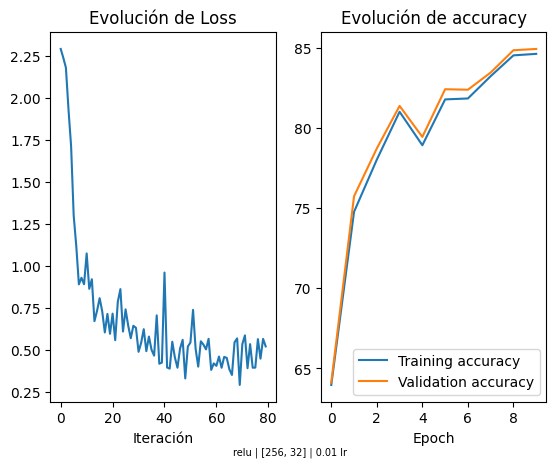

In [46]:
evaluacion(loss, train_acc, val_acc, "relu | [256, 32] | 0.01 lr")

#### Learning rate 0.1

In [47]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 1.205321  [ 6464/50000]
loss: 0.889304  [12864/50000]
loss: 0.730088  [19264/50000]
loss: 0.585269  [25664/50000]
loss: 0.617229  [32064/50000]
loss: 0.525786  [38464/50000]
loss: 0.359569  [44864/50000]
Train Acc 75.33% | Val Acc 75.92%
Epoch 2
-------------------------------
loss: 0.646831  [   64/50000]
loss: 0.428196  [ 6464/50000]
loss: 0.719791  [12864/50000]
loss: 0.353819  [19264/50000]
loss: 0.474513  [25664/50000]
loss: 0.403299  [32064/50000]
loss: 0.441929  [38464/50000]
loss: 0.467001  [44864/50000]
Train Acc 84.92% | Val Acc 85.05%
Epoch 3
-------------------------------
loss: 0.470070  [   64/50000]
loss: 0.393350  [ 6464/50000]
loss: 0.310938  [12864/50000]
loss: 0.466556  [19264/50000]
loss: 0.419991  [25664/50000]
loss: 0.458049  [32064/50000]
loss: 0.497372  [38464/50000]
loss: 0.633563  [44864/50000]
Train Acc 77.91% | Val Acc 78.06%
Epoch 4
-------------------------------
loss: 0.450940  [ 

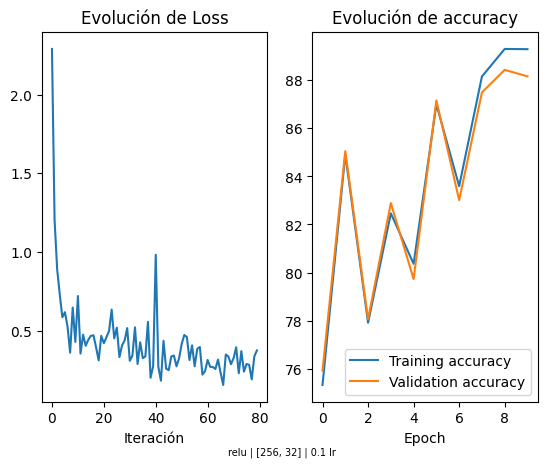

In [48]:
evaluacion(loss, train_acc, val_acc, "relu | [256, 32] | 0.1 lr")

#### Learning rate 0.3

In [49]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 1.325111  [ 6464/50000]
loss: 0.910658  [12864/50000]
loss: 0.662047  [19264/50000]
loss: 0.494467  [25664/50000]
loss: 0.553171  [32064/50000]
loss: 0.424410  [38464/50000]
loss: 0.374835  [44864/50000]
Train Acc 77.24% | Val Acc 77.95%
Epoch 2
-------------------------------
loss: 0.531702  [   64/50000]
loss: 0.411101  [ 6464/50000]
loss: 0.678671  [12864/50000]
loss: 0.358364  [19264/50000]
loss: 0.398675  [25664/50000]
loss: 0.332367  [32064/50000]
loss: 0.461942  [38464/50000]
loss: 0.447134  [44864/50000]
Train Acc 85.35% | Val Acc 85.85%
Epoch 3
-------------------------------
loss: 0.486424  [   64/50000]
loss: 0.319246  [ 6464/50000]
loss: 0.258098  [12864/50000]
loss: 0.443837  [19264/50000]
loss: 0.368592  [25664/50000]
loss: 0.422484  [32064/50000]
loss: 0.495621  [38464/50000]
loss: 0.629363  [44864/50000]
Train Acc 82.94% | Val Acc 83.37%
Epoch 4
-------------------------------
loss: 0.473286  [ 

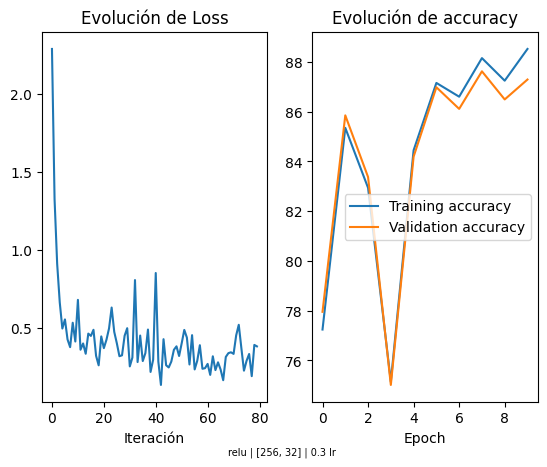

In [50]:
evaluacion(loss, train_acc, val_acc, "relu | [256, 32] | 0.3 lr")

## Probando una red más profunda
En proceso anterior buscamos combinaciones de parametos con hasta 4 capas de profundidad, pero ¿que pasaría si buscamos una red de más profundidad?


### Prueba red profunda 1

In [ ]:
#### Learning rate 0.001

In [51]:
seeds(8)
activation_name = "tanh"
hidden_units = [64, 64, 64, 64, 64, 64]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.307926  [   64/50000]
loss: 2.303246  [ 6464/50000]
loss: 2.310140  [12864/50000]
loss: 2.303868  [19264/50000]
loss: 2.303362  [25664/50000]
loss: 2.298584  [32064/50000]
loss: 2.311208  [38464/50000]
loss: 2.302806  [44864/50000]
Train Acc 10.07% | Val Acc 9.65%
Epoch 2
-------------------------------
loss: 2.304701  [   64/50000]
loss: 2.286335  [ 6464/50000]
loss: 2.301378  [12864/50000]
loss: 2.294298  [19264/50000]
loss: 2.299073  [25664/50000]
loss: 2.295045  [32064/50000]
loss: 2.295486  [38464/50000]
loss: 2.300006  [44864/50000]
Train Acc 10.07% | Val Acc 9.65%
Epoch 3
-------------------------------
loss: 2.300639  [   64/50000]
loss: 2.301277  [ 6464/50000]
loss: 2.298080  [12864/50000]
loss: 2.303015  [19264/50000]
loss: 2.295719  [25664/50000]
loss: 2.301932  [32064/50000]
loss: 2.285136  [38464/50000]
loss: 2.297366  [44864/50000]
Train Acc 10.07% | Val Acc 9.65%
Epoch 4
-------------------------------
loss: 2.293058  [   6

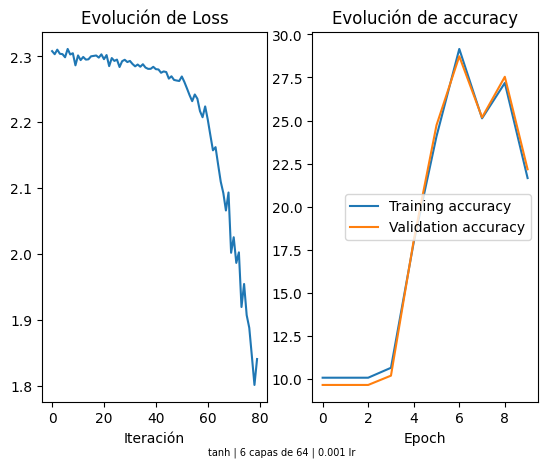

In [52]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 64 | 0.001 lr")

#### Learning rate 0.01

In [53]:
seeds(8)
activation_name = "tanh"
hidden_units = [64, 64, 64, 64, 64, 64]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.307926  [   64/50000]
loss: 2.299141  [ 6464/50000]
loss: 2.300233  [12864/50000]
loss: 2.290995  [19264/50000]
loss: 2.275528  [25664/50000]
loss: 2.258602  [32064/50000]
loss: 2.178412  [38464/50000]
loss: 1.949400  [44864/50000]
Train Acc 21.91% | Val Acc 22.35%
Epoch 2
-------------------------------
loss: 1.751854  [   64/50000]
loss: 1.736639  [ 6464/50000]
loss: 1.616302  [12864/50000]
loss: 1.590087  [19264/50000]
loss: 1.461651  [25664/50000]
loss: 1.262558  [32064/50000]
loss: 1.287379  [38464/50000]
loss: 1.234378  [44864/50000]
Train Acc 54.61% | Val Acc 54.85%
Epoch 3
-------------------------------
loss: 1.214983  [   64/50000]
loss: 1.059779  [ 6464/50000]
loss: 1.080404  [12864/50000]
loss: 1.062529  [19264/50000]
loss: 0.971312  [25664/50000]
loss: 0.996514  [32064/50000]
loss: 1.048126  [38464/50000]
loss: 1.074383  [44864/50000]
Train Acc 63.28% | Val Acc 64.05%
Epoch 4
-------------------------------
loss: 0.922750  [ 

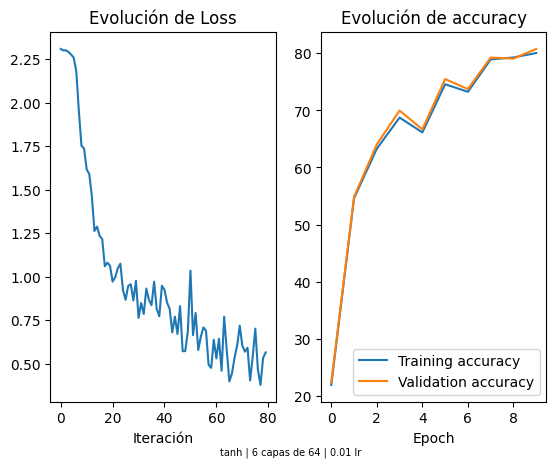

In [54]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 64 | 0.01 lr")

#### Learning rate 0.1

In [55]:
seeds(8)
activation_name = "tanh"
hidden_units = [64, 64, 64, 64, 64, 64]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.307926  [   64/50000]
loss: 1.668419  [ 6464/50000]
loss: 1.170503  [12864/50000]
loss: 1.032592  [19264/50000]
loss: 0.851110  [25664/50000]
loss: 0.717557  [32064/50000]
loss: 0.822114  [38464/50000]
loss: 0.551646  [44864/50000]
Train Acc 70.32% | Val Acc 70.95%
Epoch 2
-------------------------------
loss: 0.687274  [   64/50000]
loss: 0.703298  [ 6464/50000]
loss: 0.514331  [12864/50000]
loss: 0.620620  [19264/50000]
loss: 0.609096  [25664/50000]
loss: 0.635275  [32064/50000]
loss: 0.584380  [38464/50000]
loss: 0.614688  [44864/50000]
Train Acc 76.88% | Val Acc 76.71%
Epoch 3
-------------------------------
loss: 0.811016  [   64/50000]
loss: 0.560937  [ 6464/50000]
loss: 0.497404  [12864/50000]
loss: 0.516038  [19264/50000]
loss: 0.302619  [25664/50000]
loss: 0.560492  [32064/50000]
loss: 0.486190  [38464/50000]
loss: 0.529112  [44864/50000]
Train Acc 79.97% | Val Acc 80.33%
Epoch 4
-------------------------------
loss: 0.373365  [ 

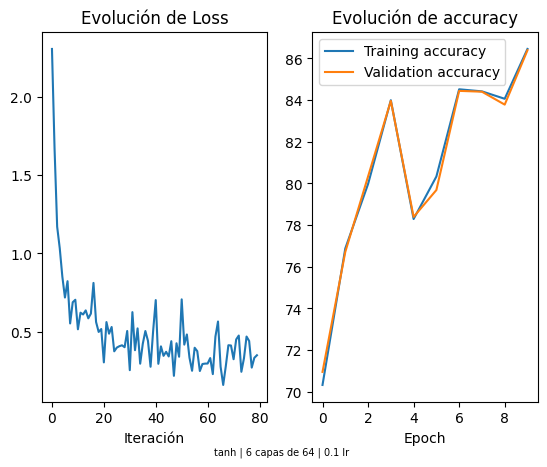

In [56]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 64 | 0.1 lr")

#### Learning rate 0.3

In [57]:
seeds(8)
activation_name = "tanh"
hidden_units = [64, 64, 64, 64, 64, 64]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.307926  [   64/50000]
loss: 1.250500  [ 6464/50000]
loss: 0.978847  [12864/50000]
loss: 0.785082  [19264/50000]
loss: 0.560573  [25664/50000]
loss: 0.526828  [32064/50000]
loss: 0.709196  [38464/50000]
loss: 0.505317  [44864/50000]
Train Acc 70.65% | Val Acc 70.96%
Epoch 2
-------------------------------
loss: 0.745060  [   64/50000]
loss: 0.748963  [ 6464/50000]
loss: 0.380969  [12864/50000]
loss: 0.497671  [19264/50000]
loss: 0.589397  [25664/50000]
loss: 0.558095  [32064/50000]
loss: 0.626071  [38464/50000]
loss: 0.447584  [44864/50000]
Train Acc 74.28% | Val Acc 73.86%
Epoch 3
-------------------------------
loss: 0.964072  [   64/50000]
loss: 0.578242  [ 6464/50000]
loss: 0.491517  [12864/50000]
loss: 0.459692  [19264/50000]
loss: 0.308816  [25664/50000]
loss: 0.538378  [32064/50000]
loss: 0.453124  [38464/50000]
loss: 0.509106  [44864/50000]
Train Acc 79.23% | Val Acc 79.59%
Epoch 4
-------------------------------
loss: 0.429037  [ 

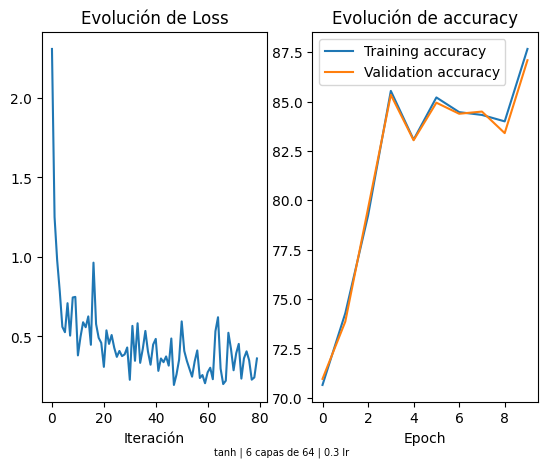

In [58]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 64 | 0.3 lr")

### Prueba red profunda 2

#### Learning rate 0.001

In [59]:
seeds(8)
activation_name = "tanh"
hidden_units = [256, 256, 256, 256, 256, 256]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.001

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.318357  [   64/50000]
loss: 2.299329  [ 6464/50000]
loss: 2.304387  [12864/50000]
loss: 2.304910  [19264/50000]
loss: 2.293425  [25664/50000]
loss: 2.296782  [32064/50000]
loss: 2.305730  [38464/50000]
loss: 2.293639  [44864/50000]
Train Acc 11.20% | Val Acc 11.32%
Epoch 2
-------------------------------
loss: 2.301445  [   64/50000]
loss: 2.293854  [ 6464/50000]
loss: 2.291844  [12864/50000]
loss: 2.291733  [19264/50000]
loss: 2.292627  [25664/50000]
loss: 2.292355  [32064/50000]
loss: 2.287910  [38464/50000]
loss: 2.285308  [44864/50000]
Train Acc 12.76% | Val Acc 12.78%
Epoch 3
-------------------------------
loss: 2.286187  [   64/50000]
loss: 2.292009  [ 6464/50000]
loss: 2.287850  [12864/50000]
loss: 2.284953  [19264/50000]
loss: 2.283815  [25664/50000]
loss: 2.280905  [32064/50000]
loss: 2.281538  [38464/50000]
loss: 2.278439  [44864/50000]
Train Acc 14.97% | Val Acc 14.93%
Epoch 4
-------------------------------
loss: 2.277205  [ 

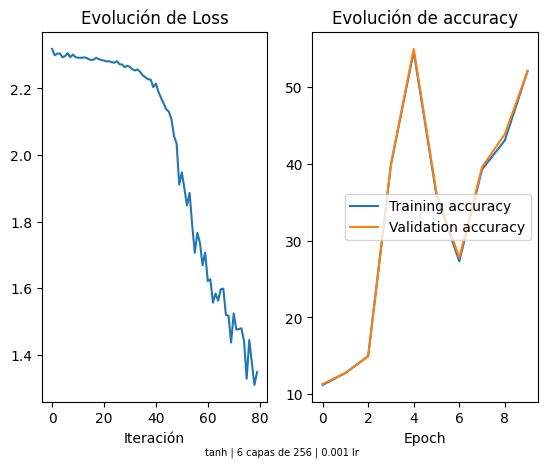

In [60]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 256 | 0.001 lr")

#### Learning rate 0.01

In [61]:
seeds(8)
activation_name = "tanh"
hidden_units = [256, 256, 256, 256, 256, 256]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.01

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.318357  [   64/50000]
loss: 2.292426  [ 6464/50000]
loss: 2.283941  [12864/50000]
loss: 2.260827  [19264/50000]
loss: 2.209692  [25664/50000]
loss: 1.943388  [32064/50000]
loss: 1.592341  [38464/50000]
loss: 1.472690  [44864/50000]
Train Acc 45.68% | Val Acc 45.22%
Epoch 2
-------------------------------
loss: 1.325563  [   64/50000]
loss: 1.212147  [ 6464/50000]
loss: 1.242641  [12864/50000]
loss: 1.127646  [19264/50000]
loss: 1.046074  [25664/50000]
loss: 1.014708  [32064/50000]
loss: 1.037793  [38464/50000]
loss: 0.951740  [44864/50000]
Train Acc 63.13% | Val Acc 63.96%
Epoch 3
-------------------------------
loss: 0.914929  [   64/50000]
loss: 0.802123  [ 6464/50000]
loss: 0.901886  [12864/50000]
loss: 0.889397  [19264/50000]
loss: 0.919526  [25664/50000]
loss: 0.720812  [32064/50000]
loss: 0.970183  [38464/50000]
loss: 0.747044  [44864/50000]
Train Acc 70.10% | Val Acc 70.77%
Epoch 4
-------------------------------
loss: 0.675887  [ 

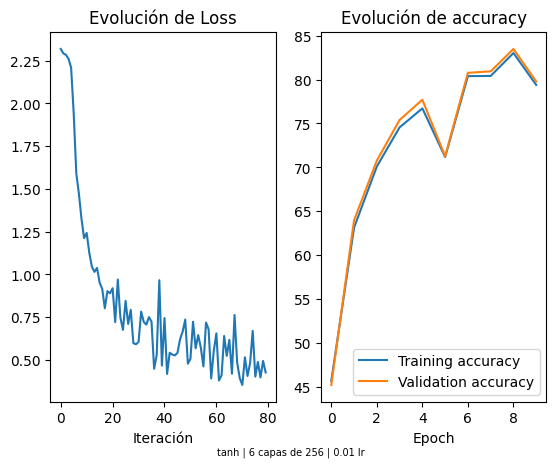

In [62]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 256 | 0.01 lr")

#### Learning rate 0.1

In [63]:
seeds(8)
activation_name = "tanh"
hidden_units = [256, 256, 256, 256, 256, 256]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.318357  [   64/50000]
loss: 1.224298  [ 6464/50000]
loss: 0.850140  [12864/50000]
loss: 0.967101  [19264/50000]
loss: 0.742129  [25664/50000]
loss: 0.788513  [32064/50000]
loss: 0.670374  [38464/50000]
loss: 0.592897  [44864/50000]
Train Acc 66.85% | Val Acc 67.56%
Epoch 2
-------------------------------
loss: 0.846321  [   64/50000]
loss: 0.302466  [ 6464/50000]
loss: 0.431338  [12864/50000]
loss: 0.496391  [19264/50000]
loss: 0.304730  [25664/50000]
loss: 0.651961  [32064/50000]
loss: 0.524475  [38464/50000]
loss: 0.487331  [44864/50000]
Train Acc 78.01% | Val Acc 78.22%
Epoch 3
-------------------------------
loss: 0.739362  [   64/50000]
loss: 0.454036  [ 6464/50000]
loss: 0.452941  [12864/50000]
loss: 0.633079  [19264/50000]
loss: 0.448526  [25664/50000]
loss: 0.498795  [32064/50000]
loss: 0.704458  [38464/50000]
loss: 0.474193  [44864/50000]
Train Acc 78.21% | Val Acc 78.42%
Epoch 4
-------------------------------
loss: 0.423325  [ 

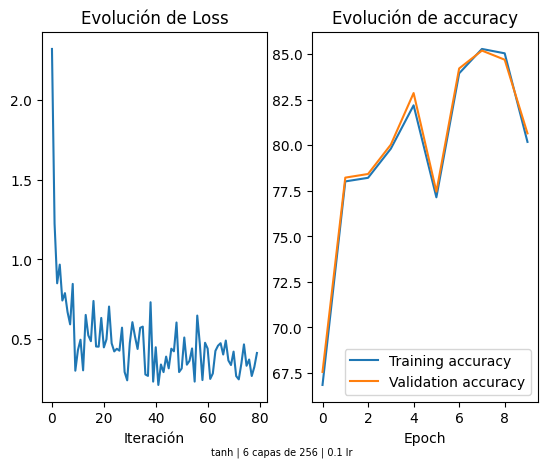

In [64]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 256 | 0.1 lr")

#### Learning rate 0.3

In [65]:
seeds(8)
activation_name = "tanh"
hidden_units = [256, 256, 256, 256, 256, 256]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.3

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 10)

Epoch 1
-------------------------------
loss: 2.318357  [   64/50000]
loss: 1.199873  [ 6464/50000]
loss: 1.268764  [12864/50000]
loss: 0.769361  [19264/50000]
loss: 0.674532  [25664/50000]
loss: 0.741419  [32064/50000]
loss: 0.610977  [38464/50000]
loss: 0.646105  [44864/50000]
Train Acc 70.45% | Val Acc 70.93%
Epoch 2
-------------------------------
loss: 0.789626  [   64/50000]
loss: 0.296051  [ 6464/50000]
loss: 0.464466  [12864/50000]
loss: 0.427248  [19264/50000]
loss: 0.298098  [25664/50000]
loss: 0.730357  [32064/50000]
loss: 0.521477  [38464/50000]
loss: 0.505319  [44864/50000]
Train Acc 80.12% | Val Acc 80.66%
Epoch 3
-------------------------------
loss: 0.693228  [   64/50000]
loss: 0.498288  [ 6464/50000]
loss: 0.545996  [12864/50000]
loss: 0.612620  [19264/50000]
loss: 0.450018  [25664/50000]
loss: 0.505885  [32064/50000]
loss: 0.578742  [38464/50000]
loss: 0.470590  [44864/50000]
Train Acc 80.99% | Val Acc 81.83%
Epoch 4
-------------------------------
loss: 0.342891  [ 

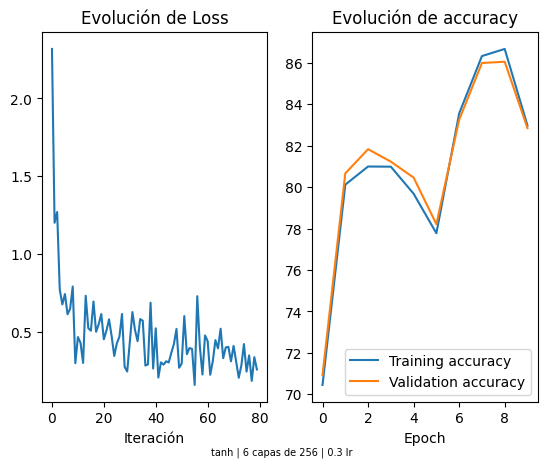

In [66]:
evaluacion(loss, train_acc, val_acc,"tanh | 6 capas de 256 | 0.3 lr")

Los mejores valores de accuracy que se registraron fueron en el entorno de 87.5, algunos modelos un poco más y otros un poco menos. De las arquitecturas más profundas probadas se observa que la accuracy estabiliza en las 10 epochs y no logra resultados similares. Esto nos permite estar seguros de haber buscado en rangos de parámetros razonables

# Aplicación de mecanismo de regulación

Probaremos 2 mecanismos de regulación:

1.  L2
2.  Dropout



Los métodos de regularización son útiles para evitar el overfitting y el entrenamiento de las redes no se observo una diferencia significativa entre la accuracy de training y validación. Entendemos que aún el modelo puede aprender de los datos y por eso pondremos más epochs de entrenamiento primero sin regularización para ver en que momento observamos overfitting y luego aplicaremos L2 y dropout para evitarlo

In [72]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]


loss: 1.205321  [ 6464/50000]
loss: 0.889304  [12864/50000]
loss: 0.730088  [19264/50000]
loss: 0.585269  [25664/50000]
loss: 0.617229  [32064/50000]
loss: 0.525786  [38464/50000]
loss: 0.359569  [44864/50000]
Train Acc 75.33% | Val Acc 75.92%
Epoch 2
-------------------------------
loss: 0.646831  [   64/50000]
loss: 0.428196  [ 6464/50000]
loss: 0.719791  [12864/50000]
loss: 0.353819  [19264/50000]
loss: 0.474513  [25664/50000]
loss: 0.403299  [32064/50000]
loss: 0.441929  [38464/50000]
loss: 0.467001  [44864/50000]
Train Acc 84.92% | Val Acc 85.05%
Epoch 3
-------------------------------
loss: 0.470070  [   64/50000]
loss: 0.393350  [ 6464/50000]
loss: 0.310938  [12864/50000]
loss: 0.466556  [19264/50000]
loss: 0.419991  [25664/50000]
loss: 0.458049  [32064/50000]
loss: 0.497372  [38464/50000]
loss: 0.633563  [44864/50000]
Train Acc 77.91% | Val Acc 78.06%
Epoch 4
-------------------------------
loss: 0.450940  [   64/50000]
loss: 0.518624  [ 6464/50000]
loss: 0.331478  [12864/50000

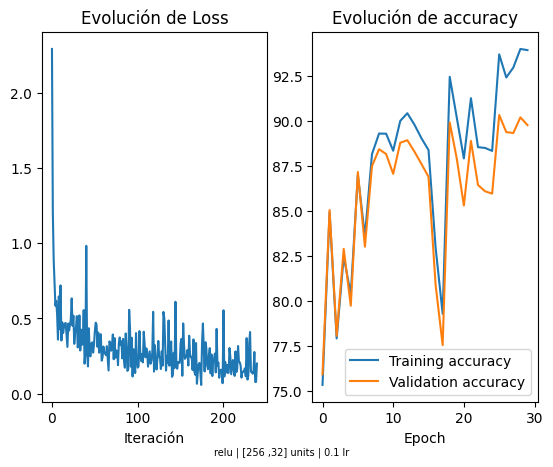

In [73]:
evaluacion(loss, train_acc, val_acc,"relu | [256 ,32] units | 0.1 lr")

In [54]:
seeds(8)
activation_name = "tanh"
hidden_units = [32, 256, 64]
modelo = NeuralNetwork(hidden_units,input_size,10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.293167  [   64/50000]
loss: 1.084288  [ 6464/50000]
loss: 0.531478  [12864/50000]
loss: 0.668405  [19264/50000]
loss: 0.479950  [25664/50000]
loss: 0.571441  [32064/50000]
loss: 0.612321  [38464/50000]
loss: 0.483076  [44864/50000]
Train Acc 80.73% | Val Acc 81.39%
Epoch 2
-------------------------------
loss: 0.404128  [   64/50000]
loss: 0.285358  [ 6464/50000]
loss: 0.813585  [12864/50000]
loss: 0.562700  [19264/50000]
loss: 0.410984  [25664/50000]
loss: 0.424444  [32064/50000]
loss: 0.412143  [38464/50000]
loss: 0.328869  [44864/50000]
Train Acc 81.32% | Val Acc 82.50%
Epoch 3
-------------------------------
loss: 0.514213  [   64/50000]
loss: 0.482914  [ 6464/50000]
loss: 0.486773  [12864/50000]
loss: 0.430031  [19264/50000]
loss: 0.269114  [25664/50000]
loss: 0.527769  [32064/50000]
loss: 0.406835  [38464/50000]
loss: 0.330767  [44864/50000]
Train Acc 81.84% | Val Acc 81.83%
Epoch 4
-------------------------------
loss: 0.478614  [ 

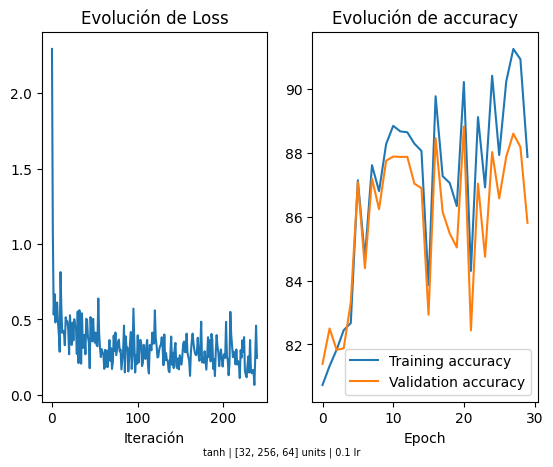

In [55]:
evaluacion(loss, train_acc, val_acc,"tanh | [32, 256, 64] units | 0.1 lr")

## Con regularización L2


#### Lambda = 0.01

In [74]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30, lmbda = 0.01)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 1.200426  [ 6464/50000]
loss: 0.927276  [12864/50000]
loss: 0.772468  [19264/50000]
loss: 0.662851  [25664/50000]
loss: 0.654306  [32064/50000]
loss: 0.584709  [38464/50000]
loss: 0.442229  [44864/50000]
Train Acc 70.31% | Val Acc 70.34%
Epoch 2
-------------------------------
loss: 0.925779  [   64/50000]
loss: 0.515680  [ 6464/50000]
loss: 0.826522  [12864/50000]
loss: 0.481285  [19264/50000]
loss: 0.642687  [25664/50000]
loss: 0.537978  [32064/50000]
loss: 0.586954  [38464/50000]
loss: 0.588780  [44864/50000]
Train Acc 82.53% | Val Acc 83.17%
Epoch 3
-------------------------------
loss: 0.540532  [   64/50000]
loss: 0.532401  [ 6464/50000]
loss: 0.439509  [12864/50000]
loss: 0.554498  [19264/50000]
loss: 0.599729  [25664/50000]
loss: 0.551401  [32064/50000]
loss: 0.639745  [38464/50000]
loss: 0.718717  [44864/50000]
Train Acc 80.38% | Val Acc 80.94%
Epoch 4
-------------------------------
loss: 0.473789  [ 

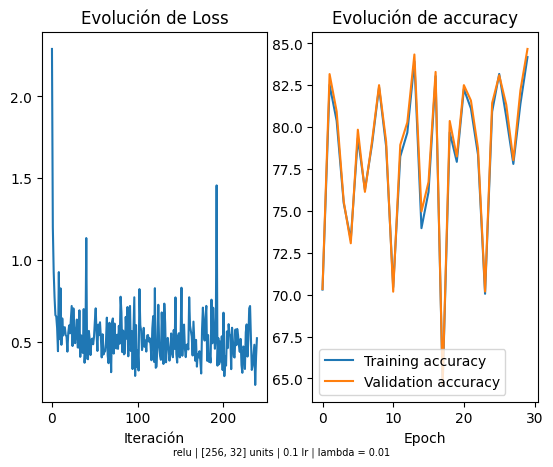

In [75]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | lambda = 0.01")

#### Lambda = 0.001

In [76]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30, lmbda = 0.001)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 1.205996  [ 6464/50000]
loss: 0.892999  [12864/50000]
loss: 0.736266  [19264/50000]
loss: 0.592092  [25664/50000]
loss: 0.615009  [32064/50000]
loss: 0.527488  [38464/50000]
loss: 0.363729  [44864/50000]
Train Acc 74.44% | Val Acc 74.80%
Epoch 2
-------------------------------
loss: 0.694683  [   64/50000]
loss: 0.438980  [ 6464/50000]
loss: 0.718279  [12864/50000]
loss: 0.359748  [19264/50000]
loss: 0.484978  [25664/50000]
loss: 0.413747  [32064/50000]
loss: 0.448539  [38464/50000]
loss: 0.483579  [44864/50000]
Train Acc 84.56% | Val Acc 84.79%
Epoch 3
-------------------------------
loss: 0.484253  [   64/50000]
loss: 0.402942  [ 6464/50000]
loss: 0.323617  [12864/50000]
loss: 0.486229  [19264/50000]
loss: 0.442930  [25664/50000]
loss: 0.482005  [32064/50000]
loss: 0.518544  [38464/50000]
loss: 0.640589  [44864/50000]
Train Acc 75.93% | Val Acc 76.33%
Epoch 4
-------------------------------
loss: 0.465686  [ 

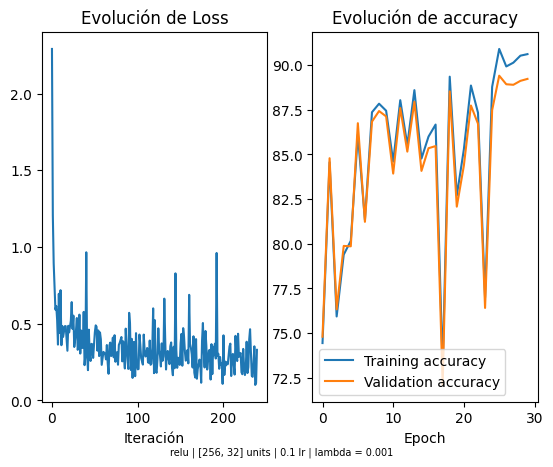

In [77]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | lambda = 0.001")

#### Lambda = 0.006

In [78]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30, lmbda = 0.006)

Epoch 1
-------------------------------
loss: 2.290382  [   64/50000]
loss: 1.199993  [ 6464/50000]
loss: 0.912916  [12864/50000]
loss: 0.758071  [19264/50000]
loss: 0.629928  [25664/50000]
loss: 0.629994  [32064/50000]
loss: 0.563506  [38464/50000]
loss: 0.402373  [44864/50000]
Train Acc 72.42% | Val Acc 72.42%
Epoch 2
-------------------------------
loss: 0.810954  [   64/50000]
loss: 0.483962  [ 6464/50000]
loss: 0.789573  [12864/50000]
loss: 0.422351  [19264/50000]
loss: 0.560865  [25664/50000]
loss: 0.489325  [32064/50000]
loss: 0.513736  [38464/50000]
loss: 0.555336  [44864/50000]
Train Acc 83.36% | Val Acc 84.06%
Epoch 3
-------------------------------
loss: 0.528938  [   64/50000]
loss: 0.475231  [ 6464/50000]
loss: 0.387811  [12864/50000]
loss: 0.522910  [19264/50000]
loss: 0.537275  [25664/50000]
loss: 0.540385  [32064/50000]
loss: 0.568839  [38464/50000]
loss: 0.696334  [44864/50000]
Train Acc 78.73% | Val Acc 79.40%
Epoch 4
-------------------------------
loss: 0.473071  [ 

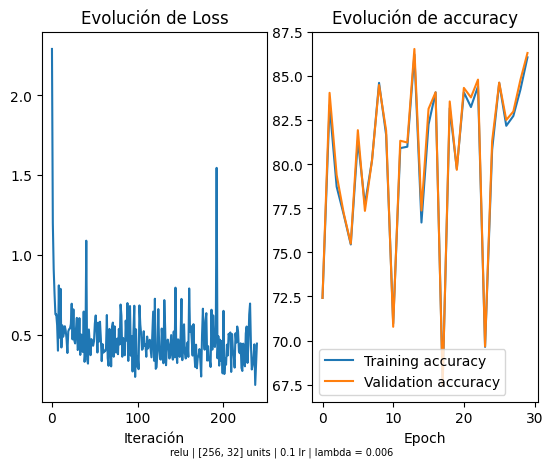

In [79]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | lambda = 0.006")

## Regularización Dropout

Probabilidad de dropout = 0.3

In [80]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name, dropout = 0.3)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.287390  [   64/50000]
loss: 1.348099  [ 6464/50000]
loss: 1.037049  [12864/50000]
loss: 0.858611  [19264/50000]
loss: 0.750205  [25664/50000]
loss: 0.773296  [32064/50000]
loss: 0.707467  [38464/50000]
loss: 0.526111  [44864/50000]
Train Acc 73.00% | Val Acc 73.47%
Epoch 2
-------------------------------
loss: 0.853248  [   64/50000]
loss: 0.434065  [ 6464/50000]
loss: 0.540647  [12864/50000]
loss: 0.766817  [19264/50000]
loss: 0.625866  [25664/50000]
loss: 0.405855  [32064/50000]
loss: 0.613689  [38464/50000]
loss: 0.488802  [44864/50000]
Train Acc 81.97% | Val Acc 82.46%
Epoch 3
-------------------------------
loss: 0.347836  [   64/50000]
loss: 0.544137  [ 6464/50000]
loss: 0.590897  [12864/50000]
loss: 0.651369  [19264/50000]
loss: 0.484870  [25664/50000]
loss: 0.477541  [32064/50000]
loss: 0.472489  [38464/50000]
loss: 0.546568  [44864/50000]
Train Acc 84.92% | Val Acc 85.29%
Epoch 4
-------------------------------
loss: 0.442497  [ 

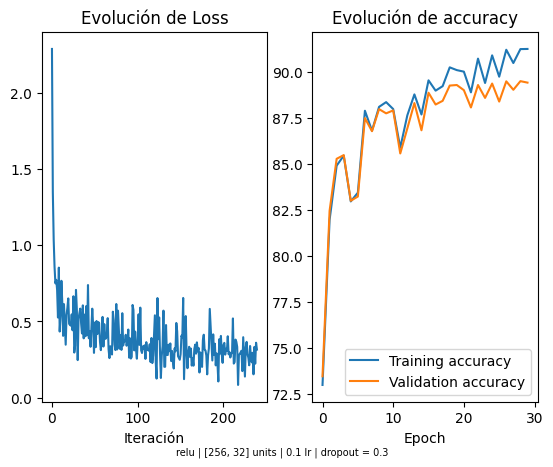

In [81]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | dropout = 0.3")

#### Probabilidad de dropout = 0.4

In [82]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name, dropout = 0.4)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.287863  [   64/50000]
loss: 1.386778  [ 6464/50000]
loss: 0.989616  [12864/50000]
loss: 0.958889  [19264/50000]
loss: 0.766315  [25664/50000]
loss: 0.793348  [32064/50000]
loss: 0.754064  [38464/50000]
loss: 0.606602  [44864/50000]
Train Acc 72.73% | Val Acc 73.08%
Epoch 2
-------------------------------
loss: 0.946331  [   64/50000]
loss: 0.545277  [ 6464/50000]
loss: 0.658234  [12864/50000]
loss: 0.859171  [19264/50000]
loss: 0.642944  [25664/50000]
loss: 0.467968  [32064/50000]
loss: 0.775723  [38464/50000]
loss: 0.576783  [44864/50000]
Train Acc 82.24% | Val Acc 82.85%
Epoch 3
-------------------------------
loss: 0.381710  [   64/50000]
loss: 0.541525  [ 6464/50000]
loss: 0.593425  [12864/50000]
loss: 0.669440  [19264/50000]
loss: 0.604332  [25664/50000]
loss: 0.513204  [32064/50000]
loss: 0.442730  [38464/50000]
loss: 0.590659  [44864/50000]
Train Acc 81.76% | Val Acc 82.18%
Epoch 4
-------------------------------
loss: 0.553045  [ 

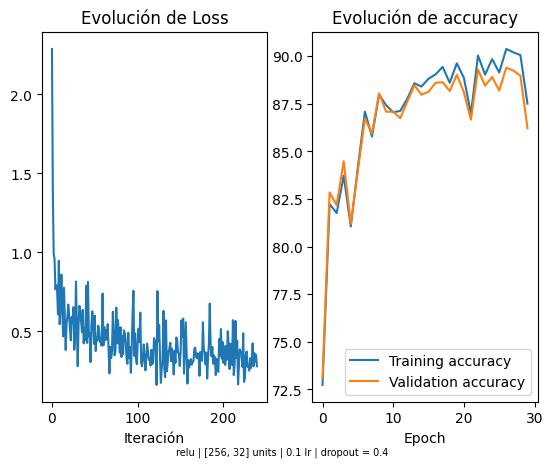

In [83]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | dropout = 0.4")

#### Probabilidad de dropout = 0.7

In [84]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name, dropout = 0.7)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.324068  [   64/50000]
loss: 1.667806  [ 6464/50000]
loss: 1.270964  [12864/50000]
loss: 1.257410  [19264/50000]
loss: 1.300013  [25664/50000]
loss: 1.258085  [32064/50000]
loss: 1.187121  [38464/50000]
loss: 0.907655  [44864/50000]
Train Acc 66.34% | Val Acc 67.09%
Epoch 2
-------------------------------
loss: 1.283722  [   64/50000]
loss: 0.849210  [ 6464/50000]
loss: 1.156767  [12864/50000]
loss: 1.128534  [19264/50000]
loss: 1.044140  [25664/50000]
loss: 0.766380  [32064/50000]
loss: 0.953939  [38464/50000]
loss: 0.919547  [44864/50000]
Train Acc 75.42% | Val Acc 76.73%
Epoch 3
-------------------------------
loss: 0.816065  [   64/50000]
loss: 0.849584  [ 6464/50000]
loss: 0.855112  [12864/50000]
loss: 1.051709  [19264/50000]
loss: 1.042785  [25664/50000]
loss: 0.849008  [32064/50000]
loss: 0.953450  [38464/50000]
loss: 1.041901  [44864/50000]
Train Acc 77.04% | Val Acc 78.12%
Epoch 4
-------------------------------
loss: 0.790247  [ 

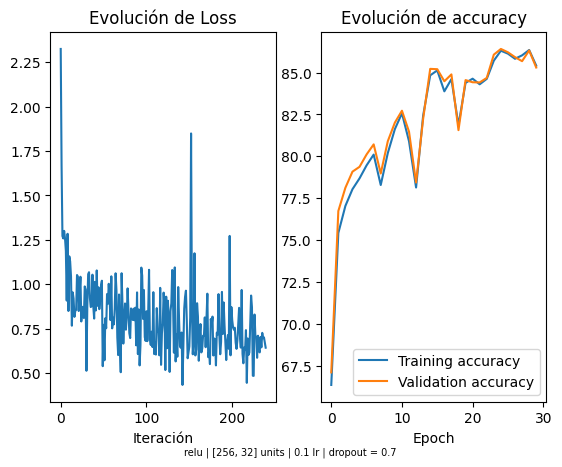

In [85]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | dropout = 0.7")

# Mejor modelo

El mejor modelo que encontramos fue .... reportó (accuracy)

Ahora podemos evaluar el modelo final en el conjunto de testeo con las métricas:
* Accuracy
* Precision
* Recall
* F1
Además de una matriz de confusión con los resultados de

In [41]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name, dropout = 0.3)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 30)

Epoch 1
-------------------------------
loss: 2.287390  [   64/50000]
loss: 1.348099  [ 6464/50000]
loss: 1.037049  [12864/50000]
loss: 0.858611  [19264/50000]
loss: 0.750205  [25664/50000]
loss: 0.773296  [32064/50000]
loss: 0.707467  [38464/50000]
loss: 0.526111  [44864/50000]
Train Acc 73.00% | Val Acc 73.47%
Epoch 2
-------------------------------
loss: 0.853247  [   64/50000]
loss: 0.428949  [ 6464/50000]
loss: 0.545078  [12864/50000]
loss: 0.757378  [19264/50000]
loss: 0.623947  [25664/50000]
loss: 0.397681  [32064/50000]
loss: 0.618868  [38464/50000]
loss: 0.481291  [44864/50000]
Train Acc 82.27% | Val Acc 82.81%
Epoch 3
-------------------------------
loss: 0.350836  [   64/50000]
loss: 0.538754  [ 6464/50000]
loss: 0.607025  [12864/50000]
loss: 0.623057  [19264/50000]
loss: 0.483951  [25664/50000]
loss: 0.460112  [32064/50000]
loss: 0.470270  [38464/50000]
loss: 0.582481  [44864/50000]
Train Acc 84.31% | Val Acc 84.63%
Epoch 4
-------------------------------
loss: 0.430781  [ 

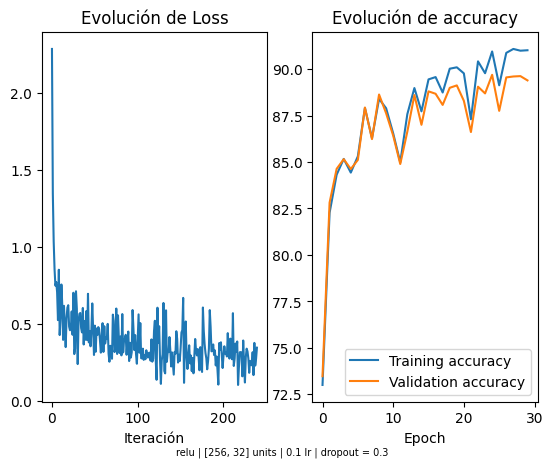

In [52]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | dropout = 0.3")

Entrenamos hasta la epoch 27 que fue la que reporta mejor accuracy

In [85]:
seeds(8)
activation_name = "relu"
hidden_units = [256, 32]
modelo = NeuralNetwork(hidden_units,input_size, 10, activation_name, dropout = 0.4)

learning_rate = 0.1

train_acc, val_acc, loss = entrena(modelo, learning_rate, epochs = 27)

Epoch 1
-------------------------------
loss: 2.287863  [   64/50000]
loss: 1.386778  [ 6464/50000]
loss: 0.989616  [12864/50000]
loss: 0.958889  [19264/50000]
loss: 0.766315  [25664/50000]
loss: 0.793348  [32064/50000]
loss: 0.754064  [38464/50000]
loss: 0.606602  [44864/50000]
Train Acc 72.73% | Val Acc 73.08%
Epoch 2
-------------------------------
loss: 0.946331  [   64/50000]
loss: 0.545277  [ 6464/50000]
loss: 0.658234  [12864/50000]
loss: 0.859171  [19264/50000]
loss: 0.642929  [25664/50000]
loss: 0.454761  [32064/50000]
loss: 0.762070  [38464/50000]
loss: 0.585437  [44864/50000]
Train Acc 81.81% | Val Acc 82.43%
Epoch 3
-------------------------------
loss: 0.389741  [   64/50000]
loss: 0.574855  [ 6464/50000]
loss: 0.604654  [12864/50000]
loss: 0.679944  [19264/50000]
loss: 0.622033  [25664/50000]
loss: 0.488532  [32064/50000]
loss: 0.439249  [38464/50000]
loss: 0.568225  [44864/50000]
Train Acc 83.11% | Val Acc 83.76%
Epoch 4
-------------------------------
loss: 0.510368  [ 

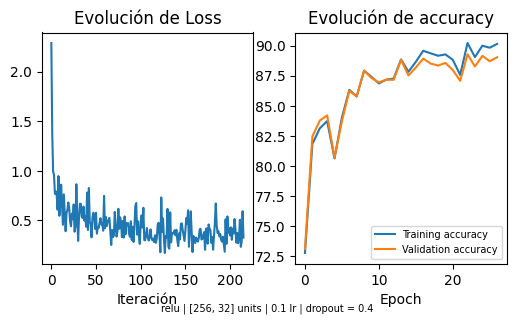

In [86]:
evaluacion(loss, train_acc, val_acc,"relu | [256, 32] units | 0.1 lr | dropout = 0.4")

In [88]:
def evaluate_model(model, dataloader):
    """
    Evalúa el modelo en el conjunto de datos y devuelve las predicciones y las etiquetas verdaderas.
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

In [89]:
def compute_metrics(predictions, true_labels, target_names=None):
    """
    Calcula y muestra métricas como precisión, recall, F1-score y una matriz de confusión.
    """
    accuracy = accuracy_score(true_labels, predictions)
    classification_rep = classification_report(true_labels, predictions, target_names=target_names)
    conf_matrix = confusion_matrix(true_labels, predictions)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_rep)
    print("Confusion Matrix:")
    return conf_matrix

In [90]:
def evaluate_and_report(model, dataloader, target_names=None):
    """
    Función completa para evaluar y reportar el rendimiento del modelo en un conjunto de datos.
    """
    predictions, true_labels = evaluate_model(model, dataloader)
    matriz = compute_metrics(predictions, true_labels, target_names)
    return matriz

Accuracy: 0.8717
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.75      0.78      1000
           3       0.87      0.91      0.89      1000
           4       0.77      0.77      0.77      1000
           5       0.96      0.96      0.96      1000
           6       0.64      0.68      0.66      1000
           7       0.94      0.93      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:


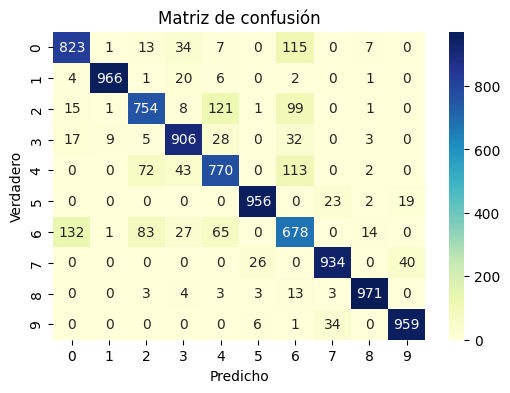

In [91]:
matriz = evaluate_and_report(modelo, test_dataloader)

plt.figure(figsize=(6, 4))  # Set the figure size
sns.heatmap(matriz, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()

# Evaluar las instancias más difíciles

In [92]:
# Evalúa el modelo en el conjunto de evaluación
def evaluate_model(model, dataloader):
    model.eval()
    entropy_values = []

    for i, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)
        probabilities = F.softmax(logits, dim=1)
        entropy = -torch.sum(probabilities * torch.log(probabilities), dim=1)
        entropy_values.extend(entropy)

    return entropy_values

In [1]:
entropy_values = evaluate_model(modelo, test_dataloader)
entropy_values = torch.tensor(entropy_values)

# Clasifica las instancias en orden descendente según su entropía
sorted_indices = torch.argsort(entropy_values, descending=True)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    row, col = divmod(i, 5) 
    index = sorted_indices[i]
    image, label = test_data[index]
    predicted_label = torch.argmax(modelo(image.view(1, -1)), dim=1).item()
    entropy = entropy_values[index]

    info_text = f"Instancia {i + 1}:\n"
    info_text += f"Etiqueta real: {label}\n"
    info_text += f"Etiqueta predicha: {predicted_label}\n"
    info_text += f"Entropía: {entropy.item():.4f}\n"

    axs[row, col].imshow(image.squeeze(), cmap="gray")
    axs[row, col].text(0, 0, info_text, fontsize=8)
    axs[row, col].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'evaluate_model' is not defined